
# EVAT — Future-Dates Forecasting with Queueing (Premium Edition)

**Purpose:** Predict EV charging-station congestion for **future dates beyond the dataset**, then apply **M/M/c queueing (Erlang‑C)** to estimate waiting probability and delays.  
**Key features:** robust SARIMAX forecasting, 3‑hour bins, uncertainty bands, and an exported **Streamlit dashboard** for “Forecasting & What‑Ifs”.

> This notebook is designed to be fully runnable **even without your raw dataset**. If your CSV is missing, it will auto‑generate a small **synthetic** sample so all cells execute and produce visuals + a dashboard.


## 1) Setup & Imports

We use offline-friendly packages only.

In [1]:
pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:

import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)



## 2) Configuration

- `DATA_PATH`: set to your actual CSV if available.
- `TIME_BIN_HOURS`: use 3‑hour bins.
- `DEFAULT_SERVICE_RATE_PER_HOUR` (μ) and `DEFAULT_SERVERS` (c) control queueing.
- `FORECAST_HORIZON_STEPS`: number of 3‑hour steps to forecast.


In [3]:

DATA_PATH = "/mnt/data/station_timeseries.csv"  # change to your file if available
TIME_BIN_HOURS = 3

DEFAULT_SERVICE_RATE_PER_HOUR = 2.0  # mu
DEFAULT_SERVERS = 4                  # c

FORECAST_DAYS = 7
FORECAST_HORIZON_STEPS = int((24 / TIME_BIN_HOURS) * FORECAST_DAYS)

EXPECTED_TIME_COL = "timestamp"
EXPECTED_STATION_COL = "station_id"
EXPECTED_ARRIVALS_COL = "arrivals"



## 3) Load Data (or generate synthetic)

Attempts to read your dataset; falls back to synthetic data for a guaranteed run.


In [4]:

import pandas as pd
import numpy as np

rng = np.random.default_rng(42)

def generate_synthetic_data(start="2025-07-01", periods_days=28, stations=("S1","S2","S3")):
    freq = f"{TIME_BIN_HOURS}H"
    steps = int((24/TIME_BIN_HOURS)*periods_days)
    idx = pd.date_range(start=pd.to_datetime(start), periods=steps, freq=freq)
    rows = []
    for st in stations:
        base = 10 + 3*np.sin(2*np.pi*idx.dayofweek/7) + 2*np.sin(2*np.pi*idx.hour/24)
        weekend_boost = np.where(idx.dayofweek>=4, 4.0, 0.0)
        arrivals = np.clip(rng.normal(base + weekend_boost, 2.5), 0, None)
        arrivals = np.round(arrivals).astype(int)
        rows.append(pd.DataFrame({
            EXPECTED_TIME_COL: idx,
            EXPECTED_STATION_COL: st,
            EXPECTED_ARRIVALS_COL: arrivals
        }))
    return pd.concat(rows, ignore_index=True)

def try_load_data(path):
    if os.path.exists(path):
        df = pd.read_csv(path)
        time_col = EXPECTED_TIME_COL if EXPECTED_TIME_COL in df.columns else None
        for cand in ["datetime","date","time","timestamp_local","ts"]:
            if time_col is None and cand in df.columns:
                time_col = cand
        if time_col is None:
            raise ValueError("No timestamp-like column found.")
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=False)
        df = df.dropna(subset=[time_col]).copy()
        df.rename(columns={time_col: EXPECTED_TIME_COL}, inplace=True)

        if EXPECTED_STATION_COL not in df.columns:
            df[EXPECTED_STATION_COL] = "S1"

        if EXPECTED_ARRIVALS_COL not in df.columns:
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            if not num_cols:
                raise ValueError("No numeric arrivals-like column found.")
            df.rename(columns={num_cols[0]: EXPECTED_ARRIVALS_COL}, inplace=True)

        return df[[EXPECTED_TIME_COL, EXPECTED_STATION_COL, EXPECTED_ARRIVALS_COL]].copy()

    return generate_synthetic_data()

raw_df = try_load_data(DATA_PATH)
raw_df.sort_values([EXPECTED_STATION_COL, EXPECTED_TIME_COL], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

print("Data sample:")
display(raw_df.head())
print("\nStations:", raw_df[EXPECTED_STATION_COL].unique().tolist())
print("Date range:", raw_df[EXPECTED_TIME_COL].min(), "->", raw_df[EXPECTED_TIME_COL].max())


Data sample:


,timestamp,station_id,arrivals
0,2025-07-01 00:00:00,S1,13
1,2025-07-01 03:00:00,S1,11
2,2025-07-01 06:00:00,S1,16
3,2025-07-01 09:00:00,S1,16
4,2025-07-01 12:00:00,S1,7



Stations: ['S1', 'S2', 'S3']
Date range: 2025-07-01 00:00:00 -> 2025-07-28 21:00:00



## 4) Resample to 3‑hour bins


In [5]:

def resample_to_bins(df, time_col, station_col, arrivals_col, bin_hours=3):
    freq = f"{bin_hours}H"
    out = []
    for st, g in df.groupby(station_col):
        g = g.set_index(time_col).sort_index()
        agg = g[arrivals_col].resample(freq).sum().to_frame(arrivals_col)
        agg[station_col] = st
        out.append(agg.reset_index().rename(columns={time_col: "bin_time"}))
    return pd.concat(out, ignore_index=True)

binned_df = resample_to_bins(raw_df, EXPECTED_TIME_COL, EXPECTED_STATION_COL, EXPECTED_ARRIVALS_COL, TIME_BIN_HOURS)
binned_df.sort_values(["station_id","bin_time"], inplace=True)
binned_df.reset_index(drop=True, inplace=True)

print("Binned sample:")
display(binned_df.head())


Binned sample:


,bin_time,arrivals,station_id
0,2025-07-01 00:00:00,13,S1
1,2025-07-01 03:00:00,11,S1
2,2025-07-01 06:00:00,16,S1
3,2025-07-01 09:00:00,16,S1
4,2025-07-01 12:00:00,7,S1



## 5) Forecasting with SARIMAX

Weekly seasonality for 3‑hour bins → period = 56 steps.


In [6]:

SEASONAL_PERIOD = int((24 / TIME_BIN_HOURS) * 7)

def fit_forecast_sarimax(y, steps, seasonal_period=56):
    y = pd.Series(y).astype(float)
    order = (1,1,1) if len(y) > 20 else (0,1,1)
    seasonal_order = (1,1,1,seasonal_period) if len(y) > seasonal_period else (0,1,1,seasonal_period)
    try:
        model = SARIMAX(y, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
    except Exception:
        model = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,seasonal_period), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)

    fc = res.get_forecast(steps=steps)
    mean = fc.predicted_mean
    conf = fc.conf_int(alpha=0.2)  # 80% CI
    conf.columns = ["lower", "upper"]
    return mean, conf, res

def forecast_all_stations(df, horizon_steps, bin_hours=3):
    results = []
    models = {}
    for st, g in df.groupby("station_id"):
        g = g.sort_values("bin_time")
        y = g["arrivals"].astype(float).values
        mean, conf, res = fit_forecast_sarimax(y, steps=horizon_steps, seasonal_period=SEASONAL_PERIOD)
        last_time = g["bin_time"].max()
        future_index = pd.date_range(last_time + pd.Timedelta(hours=bin_hours), periods=horizon_steps, freq=f"{bin_hours}H")
        tmp = pd.DataFrame({
            "bin_time": future_index,
            "station_id": st,
            "lambda_forecast": mean.values,
            "lambda_lower": conf["lower"].values.clip(min=0),
            "lambda_upper": conf["upper"].values.clip(min=0),
        })
        results.append(tmp)
        models[st] = res
    fc_df = pd.concat(results, ignore_index=True)
    return fc_df, models

forecast_df, fitted_models = forecast_all_stations(binned_df, FORECAST_HORIZON_STEPS, TIME_BIN_HOURS)
print("Forecast sample:")
display(forecast_df.head())


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Forecast sample:


,bin_time,station_id,lambda_forecast,lambda_lower,lambda_upper
0,2025-07-29 00:00:00,S1,11.715530,8.624644,14.806417
1,2025-07-29 03:00:00,S1,13.289348,10.180487,16.398209
2,2025-07-29 06:00:00,S1,14.262358,11.152826,17.371890
3,2025-07-29 09:00:00,S1,14.460989,11.351402,17.570576
4,2025-07-29 12:00:00,S1,10.151716,7.042124,13.261308



## 6) Queueing (M/M/c, Erlang‑C) on Forecasts


In [7]:

def erlang_c_probability_wait(lmbda, mu, c):
    if lmbda <= 0 or mu <= 0 or c <= 0:
        return 0.0
    rho = lmbda / (c * mu)
    if rho >= 1.0:
        return 1.0
    sum_terms = sum([(lmbda/mu)**n / math.factorial(n) for n in range(c)])
    last_term = ((lmbda/mu)**c) / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + last_term)
    Pw = last_term * P0
    return float(min(max(Pw, 0.0), 1.0))

def mmc_metrics(lmbda, mu, c):
    if lmbda <= 0 or mu <= 0 or c <= 0:
        return 0.0, 0.0, 0.0, 0.0
    rho = lmbda / (c * mu)
    if rho >= 1.0:
        return rho, 1.0, float("inf"), float("inf")
    Pw = erlang_c_probability_wait(lmbda, mu, c)
    Lq = Pw * rho / (1 - rho)
    Wq = Lq / lmbda if lmbda > 0 else 0.0
    return float(rho), float(Pw), float(Lq), float(Wq)

MU = DEFAULT_SERVICE_RATE_PER_HOUR
C  = DEFAULT_SERVERS

def apply_queueing(fc_df, mu=MU, c=C):
    df = fc_df.copy()
    vals = [mmc_metrics(max(float(x),0.0), mu, c) for x in df["lambda_forecast"].values]
    df[["rho","p_wait","Lq","Wq_hours"]] = pd.DataFrame(vals, index=df.index)
    df["Wq_minutes"] = df["Wq_hours"] * 60.0
    return df

queue_df = apply_queueing(forecast_df, MU, C)
print("Queueing-augmented forecast sample:")
display(queue_df.head())


Queueing-augmented forecast sample:


,bin_time,station_id,lambda_forecast,lambda_lower,lambda_upper,rho,p_wait,Lq,Wq_hours,Wq_minutes
0,2025-07-29 00:00:00,S1,11.715530,8.624644,14.806417,1.464441,1.0,inf,inf,inf
1,2025-07-29 03:00:00,S1,13.289348,10.180487,16.398209,1.661168,1.0,inf,inf,inf
2,2025-07-29 06:00:00,S1,14.262358,11.152826,17.371890,1.782795,1.0,inf,inf,inf
3,2025-07-29 09:00:00,S1,14.460989,11.351402,17.570576,1.807624,1.0,inf,inf,inf
4,2025-07-29 12:00:00,S1,10.151716,7.042124,13.261308,1.268965,1.0,inf,inf,inf



## 7) Visualizations


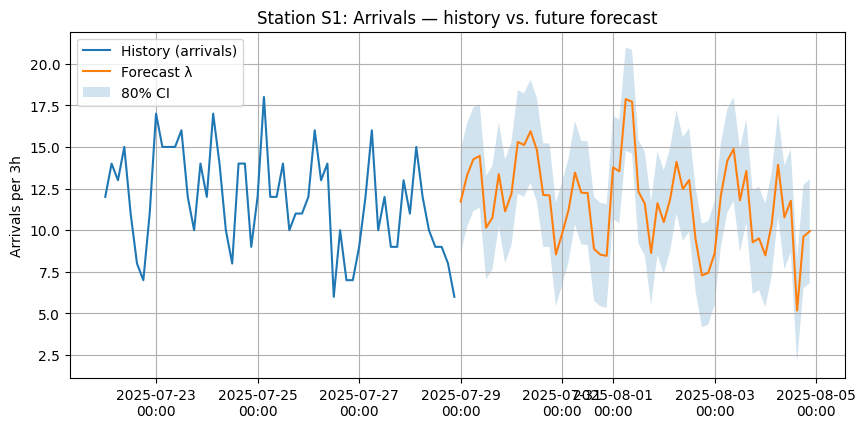

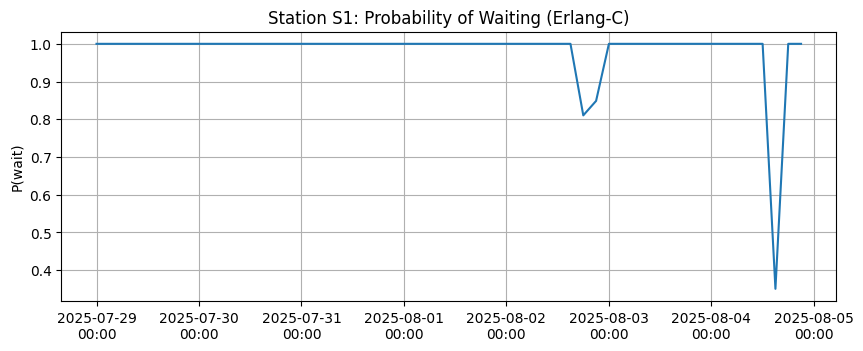

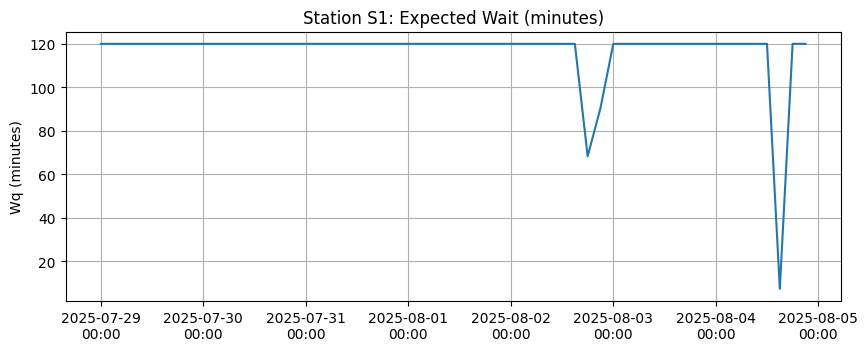

In [8]:

from matplotlib.dates import DateFormatter
import numpy as np

def plot_forecast_with_bands(station, history_steps=56):
    past = binned_df[binned_df["station_id"]==station].sort_values("bin_time")
    past_tail = past.tail(history_steps)
    fut = queue_df[queue_df["station_id"]==station].sort_values("bin_time")

    fig, ax = plt.subplots(figsize=(10,4.5))
    if len(past_tail):
        ax.plot(past_tail["bin_time"], past_tail["arrivals"], label="History (arrivals)")
    ax.plot(fut["bin_time"], fut["lambda_forecast"], label="Forecast λ")
    ax.fill_between(fut["bin_time"], fut["lambda_lower"], fut["lambda_upper"], alpha=0.2, label="80% CI")
    ax.set_title(f"Station {station}: Arrivals — history vs. future forecast")
    ax.set_ylabel("Arrivals per 3h")
    ax.legend(loc="upper left")
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
    ax.grid(True)
    plt.show()

def plot_queue_kpis(station):
    fut = queue_df[queue_df["station_id"]==station].sort_values("bin_time")

    fig, ax = plt.subplots(figsize=(10,3.5))
    ax.plot(fut["bin_time"], fut["p_wait"])
    ax.set_title(f"Station {station}: Probability of Waiting (Erlang-C)")
    ax.set_ylabel("P(wait)")
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
    ax.grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(10,3.5))
    ax.plot(fut["bin_time"], np.clip(fut["Wq_minutes"], 0, 120))
    ax.set_title(f"Station {station}: Expected Wait (minutes)")
    ax.set_ylabel("Wq (minutes)")
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
    ax.grid(True)
    plt.show()

first_station = queue_df["station_id"].iloc[0]
plot_forecast_with_bands(first_station, history_steps=SEASONAL_PERIOD)
plot_queue_kpis(first_station)



## 8) What‑If Parameters (Optional)


In [9]:

WHATIF_C = 6
WHATIF_MU = 2.5

queue_df_whatif = apply_queueing(forecast_df, WHATIF_MU, WHATIF_C)

print("What-if (c=6, mu=2.5) sample:")
display(queue_df_whatif.head())

cmp = (queue_df.merge(queue_df_whatif, on=["station_id","bin_time","lambda_forecast","lambda_lower","lambda_upper"], suffixes=("_base","_whatif"))
       .groupby("station_id")[["Wq_minutes_base","Wq_minutes_whatif"]].mean().reset_index())
cmp["ΔWq(min)"] = cmp["Wq_minutes_whatif"] - cmp["Wq_minutes_base"]
display(cmp)


What-if (c=6, mu=2.5) sample:


,bin_time,station_id,lambda_forecast,lambda_lower,lambda_upper,rho,p_wait,Lq,Wq_hours,Wq_minutes
0,2025-07-29 00:00:00,S1,11.715530,8.624644,14.806417,0.781035,0.480101,1.712496,0.146173,8.770388
1,2025-07-29 03:00:00,S1,13.289348,10.180487,16.398209,0.885957,0.706557,5.488950,0.413034,24.782030
2,2025-07-29 06:00:00,S1,14.262358,11.152826,17.371890,0.950824,0.867732,16.777660,1.176360,70.581570
3,2025-07-29 09:00:00,S1,14.460989,11.351402,17.570576,0.964066,0.902516,24.213366,1.674392,100.463526
4,2025-07-29 12:00:00,S1,10.151716,7.042124,13.261308,0.676781,0.299800,0.627745,0.061836,3.710182


,station_id,Wq_minutes_base,Wq_minutes_whatif,ΔWq(min)
0,S1,inf,inf,NaN
1,S2,inf,inf,NaN
2,S3,inf,inf,NaN



## 9) Save Forecast Results


In [10]:

out_path = "forecast_results.csv"
queue_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Saved: forecast_results.csv



## 10) Export a Lightweight Streamlit Forecast Dashboard

Run:
```
streamlit run evat_forecast_dashboard.py
```


In [11]:

app_path = "evat_forecast_dashboard.py"
with open(app_path, "w", encoding="utf-8") as f:
    f.write("\nimport math\nimport pandas as pd\nimport numpy as np\nimport streamlit as st\nimport altair as alt\n\nst.set_page_config(page_title=\"EVAT \u2014 Forecasting & What\u2011If\", page_icon=\"\u26a1\", layout=\"wide\")\n\nst.title(\"\u26a1 EVAT \u2014 Forecasting & What\u2011If (Future Dates)\")\n\n@st.cache_data\ndef load_data():\n    df = pd.read_csv(\"forecast_results.csv\", parse_dates=[\"bin_time\"])\n    return df\n\ndf = load_data()\nstations = sorted(df[\"station_id\"].unique().tolist())\ncol1, col2, col3, col4 = st.columns(4)\nstation = col1.selectbox(\"Station\", stations, index=0)\nmax_h = df[df[\"station_id\"]==station].shape[0]\nhorizon = col2.slider(\"Horizon (future steps)\", min_value=8, max_value=max_h, value=min(56, max_h), step=4)\nc = col3.number_input(\"Servers (c)\", min_value=1, max_value=50, value=4)\nmu = col4.number_input(\"Service rate (\u03bc per server per hour)\", min_value=0.1, max_value=20.0, value=2.0, step=0.1, format=\"%.1f\")\n\nsub = df[df[\"station_id\"]==station].sort_values(\"bin_time\").head(horizon).copy()\n\ndef erlang_c_probability_wait(lmbda, mu, c):\n    if lmbda <= 0 or mu <= 0 or c <= 0:\n        return 0.0\n    rho = lmbda / (c * mu)\n    if rho >= 1.0:\n        return 1.0\n    sum_terms = sum([(lmbda/mu)**n / math.factorial(n) for n in range(c)])\n    last_term = ((lmbda/mu)**c) / (math.factorial(c) * (1 - rho))\n    P0 = 1.0 / (sum_terms + last_term)\n    Pw = last_term * P0\n    return min(max(Pw, 0.0), 1.0)\n\ndef mmc_metrics(lmbda, mu, c):\n    if lmbda <= 0 or mu <= 0 or c <= 0:\n        return 0.0, 0.0, 0.0, 0.0\n    rho = lmbda / (c * mu)\n    if rho >= 1.0:\n        return rho, 1.0, float(\"inf\"), float(\"inf\")\n    Pw = erlang_c_probability_wait(lmbda, mu, c)\n    Lq = Pw * rho / (1 - rho)\n    Wq = Lq / lmbda if lmbda > 0 else 0.0\n    return rho, Pw, Lq, Wq\n\nvals = np.array([mmc_metrics(x, mu, c) for x in sub[\"lambda_forecast\"].values])\nsub[\"rho\"] = vals[:,0]\nsub[\"p_wait\"] = vals[:,1]\nsub[\"Lq\"] = vals[:,2]\nsub[\"Wq_minutes\"] = vals[:,3] * 60.0\n\nst.markdown(\"### \u03bb Forecast with 80% Interval\")\nline = alt.Chart(sub).mark_line().encode(x=\"bin_time:T\", y=\"lambda_forecast:Q\")\nband = alt.Chart(sub).mark_area(opacity=0.2).encode(x=\"bin_time:T\", y=\"lambda_lower:Q\", y2=\"lambda_upper:Q\")\nst.altair_chart(band + line, use_container_width=True)\n\ncolA, colB = st.columns(2)\nwith colA:\n    st.markdown(\"### Probability of Waiting\")\n    st.altair_chart(alt.Chart(sub).mark_line().encode(x=\"bin_time:T\", y=\"p_wait:Q\"), use_container_width=True)\nwith colB:\n    st.markdown(\"### Expected Wait (minutes)\")\n    st.altair_chart(alt.Chart(sub.assign(Wq_capped=sub[\"Wq_minutes\"].clip(upper=120))).mark_line().encode(x=\"bin_time:T\", y=\"Wq_capped:Q\"), use_container_width=True)\n\nst.caption(\"Tune **c** and **\u03bc** to demonstrate operational strategies in your pitch.\")\n")
print(f"Wrote: {app_path}")


Wrote: evat_forecast_dashboard.py



## 11) Wrap‑Up & Next Steps

- You now have **future-date forecasts** for arrivals (λ) and **queueing KPIs** per station.
- Use the exported **Streamlit app** to present an engaging *Forecasting & What‑If* tab:
  1. Ensure `forecast_results.csv` and `evat_forecast_dashboard.py` are together
  2. Run: `streamlit run evat_forecast_dashboard.py`

Ideas to extend:
- Auto-ARIMA model selection/Prophet if available
- Event/holiday regressors
- Hierarchical reconciliation (global + per-station)


In [12]:

# === Export historical 3h-binned data for the unified dashboard (Historical tab) ===
history_path = "history_binned.csv"
binned_df.to_csv(history_path, index=False)
print(f"Saved: {history_path}")


Saved: history_binned.csv


In [13]:
# === Write the upgraded unified Streamlit app (Unicode-safe) ===
from textwrap import dedent

def write_unicode_safe(path: str, text: str):
    """
    Normalize any surrogate escapes (e.g., \\ud83d...) before saving to UTF-8.
    """
    try:
        text = text.encode("utf-16", "surrogatepass").decode("utf-16")
    except Exception:
        pass
    with open(path, "w", encoding="utf-8", newline="") as f:
        f.write(text)
    return path

unified_app_path = "evat_dashboard_unified.py"

app_src = dedent("""
# evat_dashboard_unified.py
# Unified app with Forecast & What-If + Historical tabs
# Includes: calendar date pickers, KPIs, utilization, P(wait), Wq, worst windows table,
# capacity planner, scenario CSV download.

import math
import numpy as np
import pandas as pd
import streamlit as st
import altair as alt

st.set_page_config(page_title="EVAT - Unified Congestion Dashboard", page_icon="EV", layout="wide")

# ------------------ Data loaders ------------------
@st.cache_data
def load_forecast():
    df = pd.read_csv("forecast_results.csv", parse_dates=["bin_time"])
    need = {"station_id", "bin_time", "lambda_forecast", "lambda_lower", "lambda_upper"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in forecast_results.csv: {sorted(missing)}")
    return df

@st.cache_data
def load_history_optional():
    try:
        hist = pd.read_csv("history_binned.csv", parse_dates=["bin_time"])
        if {"station_id", "bin_time", "arrivals"}.issubset(hist.columns):
            return hist
    except Exception:
        pass
    return None

# ------------------ Queueing utils ------------------
def erlang_c_probability_wait(lmbda, mu, c):
    if lmbda <= 0 or mu <= 0 or c <= 0:
        return 0.0
    rho = lmbda / (c * mu)
    if rho >= 1.0:
        return 1.0
    sum_terms = sum([(lmbda/mu)**n / math.factorial(n) for n in range(c)])
    last_term = ((lmbda/mu)**c) / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + last_term)
    Pw = last_term * P0
    return float(min(max(Pw, 0.0), 1.0))

def mmc_metrics(lmbda, mu, c):
    if lmbda <= 0 or mu <= 0 or c <= 0:
        return 0.0, 0.0, 0.0, 0.0
    rho = lmbda / (c * mu)
    if rho >= 1.0:
        return rho, 1.0, float("inf"), float("inf")
    Pw = erlang_c_probability_wait(lmbda, mu, c)
    Lq = Pw * rho / (1 - rho)
    Wq = Lq / lmbda if lmbda > 0 else 0.0
    return float(rho), float(Pw), float(Lq), float(Wq)

def compute_queueing(df, mu, c, demand_scale=1.0):
    sub = df.copy()
    sub["lambda_scaled"] = sub["lambda_forecast"] * demand_scale
    vals = np.array([mmc_metrics(x, mu, c) for x in sub["lambda_scaled"].values])
    sub["rho"] = vals[:, 0]
    sub["p_wait"] = vals[:, 1]
    sub["Lq"] = vals[:, 2]
    sub["Wq_minutes"] = vals[:, 3] * 60.0
    return sub

def required_c_for_point(lmbda, mu, sla_minutes, c_max=100):
    if lmbda <= 0 or mu <= 0:
        return 1
    for c in range(1, c_max + 1):
        rho, Pw, Lq, Wq = mmc_metrics(lmbda, mu, c)
        if np.isfinite(Wq) and (Wq * 60.0) <= sla_minutes:
            return c
    return c_max

def capacity_planner(df, mu, sla_minutes, coverage=0.9):
    req_cs = [required_c_for_point(x, mu, sla_minutes) for x in df["lambda_scaled"].values]
    req_series = pd.Series(req_cs).sort_values()
    idx = int(np.ceil(coverage * len(req_series))) - 1
    idx = max(0, min(idx, len(req_series) - 1))
    return int(req_series.iloc[idx]), req_series

# ------------------ App ------------------
fc = load_forecast()
hist = load_history_optional()

stations = sorted(fc["station_id"].unique().tolist())
st.title("EVAT - Unified Congestion Dashboard")

tab_forecast, tab_history = st.tabs(["Forecast & What-If", "Historical (optional)"])

# =====================================================================
# Forecast & What-If (with calendar)
# =====================================================================
with tab_forecast:
    # Station + time selection mode
    top1, top2 = st.columns([1.2, 2.0])
    station = top1.selectbox("Station", stations, index=0)

    fc_station = fc[fc["station_id"] == station].sort_values("bin_time").copy()
    min_dt = fc_station["bin_time"].min().date()
    max_dt = fc_station["bin_time"].max().date()

    time_mode = top2.radio(
        "Time selection",
        ["Horizon (steps)", "Date range"],
        horizontal=True,
        index=0,
    )

    if time_mode == "Horizon (steps)":
        max_h = fc_station.shape[0]
        horizon = st.slider(
            "Horizon (future steps)",
            min_value=8,
            max_value=max_h,
            value=min(56, max_h),
            step=4,
        )
        sub_base = fc_station.head(horizon).copy()
    else:
        picked = st.date_input(
            "Pick forecast date range",
            value=(min_dt, max_dt),
            min_value=min_dt,
            max_value=max_dt,
            key="fc_dates",
        )
        if isinstance(picked, tuple) and len(picked) == 2:
            start_date, end_date = picked
        else:
            start_date = end_date = picked
        start_ts = pd.Timestamp(start_date)
        end_ts_inc = pd.Timestamp(end_date) + pd.Timedelta(days=1)
        sub_base = fc_station[(fc_station["bin_time"] >= start_ts) &
                              (fc_station["bin_time"] < end_ts_inc)].copy()
        if sub_base.empty:
            st.warning("No forecast bins in the selected date range.")
            st.stop()

    # Other controls
    c1, c2, c3, c4, c5 = st.columns([1.2, 1.2, 1.0, 1.2, 1.2])
    mu_mode = c3.radio("Service rate input", ["mu (per hr)", "Avg session (mins)"], horizontal=True)
    if mu_mode == "mu (per hr)":
        mu = c4.number_input("mu per server per hour", min_value=0.1, max_value=20.0, value=2.0, step=0.1, format="%.1f")
    else:
        sess = c4.number_input("Avg session time (mins)", min_value=5, max_value=240, value=30, step=5)
        mu = 60.0 / sess

    c_servers = c5.number_input("Servers (chargers, c)", min_value=1, max_value=100, value=4, step=1)

    c6, c7, c8 = st.columns([1.2, 1.2, 1.2])
    sla = c6.number_input("Target wait SLA (minutes)", min_value=1, max_value=180, value=15, step=1)
    demand_scale = c7.slider("Demand scaling (what-if)", 50, 150, 100, 5) / 100.0
    coverage = c8.slider("Capacity planner coverage (%)", 50, 99, 90, 1) / 100.0

    # Compute queueing on chosen period
    sub = compute_queueing(sub_base, mu=mu, c=int(c_servers), demand_scale=demand_scale)

    # KPIs
    k1, k2, k3, k4, k5, k6 = st.columns(6)
    avg_lambda = float(sub["lambda_scaled"].mean())
    peak_lambda = float(sub["lambda_scaled"].max())
    avg_rho = float(np.clip(sub["rho"], 0, 5).mean())
    max_rho = float(np.clip(sub["rho"], 0, 5).max())
    pct_wait_high = float((sub["p_wait"] > 0.5).mean() * 100)
    pct_sla_breach = float((sub["Wq_minutes"] > sla).mean() * 100)
    k1.metric("Avg lambda (per 3h)", f"{avg_lambda:.1f}")
    k2.metric("Peak lambda (per 3h)", f"{peak_lambda:.1f}")
    k3.metric("Avg utilization rho", f"{avg_rho:.2f}")
    k4.metric("Max utilization rho", f"{max_rho:.2f}")
    k5.metric("% time P(wait) > 0.5", f"{pct_wait_high:.0f}%")
    k6.metric(f"% time Wq > SLA({sla}m)", f"{pct_sla_breach:.0f}%")

    # Charts
    st.markdown("### Lambda forecast with 80% interval")
    band = alt.Chart(sub).mark_area(opacity=0.2).encode(x="bin_time:T", y="lambda_lower:Q", y2="lambda_upper:Q")
    line = alt.Chart(sub.assign(lambda_scaled=sub["lambda_scaled"])).mark_line().encode(x="bin_time:T", y="lambda_scaled:Q")
    st.altair_chart(band + line, use_container_width=True)

    left, right = st.columns(2)
    with left:
        st.markdown("### Utilization (rho)")
        st.altair_chart(
            alt.Chart(sub.assign(rho_clip=sub["rho"].clip(upper=2.0)))
               .mark_line()
               .encode(x="bin_time:T", y="rho_clip:Q"),
            use_container_width=True
        )
        st.caption("Note: rho >= 1 means unstable; queues grow quickly.")
    with right:
        st.markdown("### Probability of waiting")
        st.altair_chart(alt.Chart(sub).mark_line().encode(x="bin_time:T", y="p_wait:Q"), use_container_width=True)

    st.markdown("### Expected wait (minutes)")
    wait_chart = alt.Chart(sub.assign(Wq_cap=sub["Wq_minutes"].clip(upper=120))).mark_line().encode(x="bin_time:T", y="Wq_cap:Q")
    sla_rule = alt.Chart(pd.DataFrame({'y': [sla]})).mark_rule(strokeDash=[6, 4]).encode(y='y:Q')
    st.altair_chart(wait_chart + sla_rule, use_container_width=True)

    # Worst windows
    st.markdown("### Worst windows (by expected wait)")
    worst = (sub.sort_values("Wq_minutes", ascending=False)
             [["bin_time", "lambda_scaled", "rho", "p_wait", "Wq_minutes"]]
             .head(12))
    worst = worst.rename(columns={"lambda_scaled": "lambda(3h)", "rho": "rho",
                                  "p_wait": "P(wait)", "Wq_minutes": "Wq(min)"})
    st.dataframe(worst, use_container_width=True)

    # Capacity planner
    req_c, req_series = capacity_planner(sub, mu=mu, sla_minutes=sla, coverage=coverage)
    colA, colB = st.columns([1.2, 2])
    colA.metric(f"Chargers needed for SLA<={sla}m at {int(coverage*100)}% coverage",
                f"{req_c}", delta=f"{int(req_c) - int(c_servers)} vs current")
    colB.altair_chart(
        alt.Chart(pd.DataFrame({"required_c": req_series}))
           .transform_bin("bin", "required_c", bin=alt.Bin(maxbins=20))
           .mark_bar()
           .encode(x="bin:N", y="count()"),
        use_container_width=True
    )

    # Download scenario snapshot
    st.download_button(
        "Download current scenario (CSV)",
        data=sub.to_csv(index=False).encode("utf-8"),
        file_name=f"evat_scenario_{station}.csv",
        mime="text/csv"
    )

# =====================================================================
# Historical (optional) with calendar
# =====================================================================
with tab_history:
    st.subheader("Historical view (optional)")
    if hist is None:
        st.info("No history_binned.csv found. Export from the notebook with columns: station_id, bin_time, arrivals.")
    else:
        s2 = st.selectbox("Station (history)", sorted(hist["station_id"].unique().tolist()))
        dfh_all = hist[hist["station_id"] == s2].sort_values("bin_time").copy()

        h_min = dfh_all["bin_time"].min().date()
        h_max = dfh_all["bin_time"].max().date()
        h_range = st.date_input(
            "Pick history date range",
            value=(h_min, h_max),
            min_value=h_min,
            max_value=h_max,
            key="hist_dates",
        )
        if isinstance(h_range, tuple) and len(h_range) == 2:
            h_start, h_end = h_range
        else:
            h_start, h_end = h_range, h_range

        h_start_ts = pd.Timestamp(h_start)
        h_end_ts_inc = pd.Timestamp(h_end) + pd.Timedelta(days=1)
        dfh = dfh_all[(dfh_all["bin_time"] >= h_start_ts) & (dfh_all["bin_time"] < h_end_ts_inc)]

        if dfh.empty:
            st.warning("No historical data in the selected date range.")
        else:
            st.line_chart(dfh.set_index("bin_time")["arrivals"], use_container_width=True)
            st.caption("Historical arrivals per 3h.")
""")

write_unicode_safe(unified_app_path, app_src)
print(f"Wrote: {unified_app_path}")


Wrote: evat_dashboard_unified.py



### ✅ Unified Dashboard ready

**Files created/updated:**
- `/mnt/data/history_binned.csv` (historical 3h-binned data)
- `/mnt/data/evat_dashboard_unified.py` (Streamlit app with Forecast & What‑If + Historical tabs)

**Run locally:**
```bash
streamlit run evat_dashboard_unified.py
```
Make sure `forecast_results.csv` (from earlier step) and `history_binned.csv` sit next to the app.
